In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from dotenv import load_dotenv
from pandas.tseries.offsets import DateOffset
import os
import requests
import datetime
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.requests import CryptoLatestQuoteRequest
from alpaca.data.requests import CryptoTradesRequest
from alpaca.data.timeframe import TimeFrame
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
import matplotlib.pyplot as plt
from numpy.lib import math

%matplotlib inline

# Youtube where I got inspiration from: https://www.youtube.com/watch?v=Whj0u6T6nBg

In [31]:
crypto_client = CryptoHistoricalDataClient()

In [32]:
request_params = CryptoBarsRequest(
    symbol_or_symbols=["ETH/USD"],
    timeframe=TimeFrame.Hour, start='2021-09-30 00:00:00'
)

eth_bars = crypto_client.get_crypto_bars(request_params)

eth_df = eth_bars.df

eth_df

open    high     low   close    volume  \
symbol  timestamp                                                             
ETH/USD 2021-09-30 00:00:00+00:00  2849.8  2934.8  2838.3  2934.2   706.304   
        2021-09-30 01:00:00+00:00  2935.8  2985.4  2918.2  2961.0   760.251   
        2021-09-30 02:00:00+00:00  2965.4  2994.4  2961.1  2990.6  3886.627   
        2021-09-30 03:00:00+00:00  2992.0  3035.8  2970.0  3029.0  5551.980   
        2021-09-30 04:00:00+00:00  3030.3  3049.2  3014.0  3017.1   401.627   
...                                   ...     ...     ...     ...       ...   
        2022-10-03 22:00:00+00:00  1318.3  1321.7  1315.4  1315.7  1063.529   
        2022-10-03 23:00:00+00:00  1315.7  1328.0  1315.7  1323.9  1721.348   
        2022-10-04 00:00:00+00:00  1323.7  1330.0  1320.8  1321.8   884.097   
        2022-10-04 01:00:00+00:00  1321.9  1324.6  1319.9  1320.0   682.791   
        2022-10-04 02:00:00+00:00  1319.9  1321.0  1319.4  1320.3   238.018   

                                   trade_count         vwap  
symbol  timestamp                                            
ETH/USD 2021-09-30 00:00:00+00:00        393.0  2887.453790  
        2021-09-30 01:00:00+00:00        352.0  2957.585712  
        2021-09-30 02:00:00+00:00        573.0  2975.692584  
        2021-09-30 03:00:00+00:00        669.0  2991.111283  
        2021-09-30 04:00:00+00:00        115.0  3030.674760  
...                                        ...          ...  
        2022-10-03 22:00:00+00:00        911.0  1317.203945  
        2022-10-03 23:00:00+00:00       1207.0  1322.397561  
        2022-10-04 00:00:00+00:00        848.0  1325.526781  
        2022-10-04 01:00:00+00:00        541.0  1323.057614  
        2022-10-04 02:00:00+00:00        187.0  1320.010043  

[8841 rows x 7 columns]

In [33]:
# Use the pct_change function to generate  returns from close prices
eth_df["Actual Returns"] = eth_df["close"].pct_change()

# Drop na
eth_df=eth_df.dropna()

#Reset the index column
eth_df = eth_df.reset_index()

# Drop Symbol Column
eth_df = eth_df.drop(columns=['symbol'])

In [34]:
# Store the target variable into 'Signal' column
# if the next day close is greater than the previous day close 'Signal' = 1,
# Otherwise 'Signal' = 0
eth_df['Signal'] = np.where(eth_df['close'].shift(-1) >= eth_df['close'], 1, 0)

eth_df

,timestamp,open,high,low,close,volume,trade_count,vwap,Actual Returns,Signal
0,2021-09-30 01:00:00+00:00,2935.8,2985.4,2918.2,2961.0,760.251,352.0,2957.585712,0.009134,1
1,2021-09-30 02:00:00+00:00,2965.4,2994.4,2961.1,2990.6,3886.627,573.0,2975.692584,0.009997,1
2,2021-09-30 03:00:00+00:00,2992.0,3035.8,2970.0,3029.0,5551.980,669.0,2991.111283,0.012840,0
3,2021-09-30 04:00:00+00:00,3030.3,3049.2,3014.0,3017.1,401.627,115.0,3030.674760,-0.003929,1
4,2021-09-30 05:00:00+00:00,3023.0,3041.3,3019.5,3029.7,141.883,108.0,3025.002656,0.004176,0
...,...,...,...,...,...,...,...,...,...,...
8835,2022-10-03 22:00:00+00:00,1318.3,1321.7,1315.4,1315.7,1063.529,911.0,1317.203945,-0.001972,1
8836,2022-10-03 23:00:00+00:00,1315.7,1328.0,1315.7,1323.9,1721.348,1207.0,1322.397561,0.006232,0
8837,2022-10-04 00:00:00+00:00,1323.7,1330.0,1320.8,1321.8,884.097,848.0,1325.526781,-0.001586,0
8838,2022-10-04 01:00:00+00:00,1321.9,1324.6,1319.9,1320.0,682.791,541.0,1323.057614,-0.001362,1


In [35]:
eth_df['High-Low'] = eth_df['high'] - eth_df['low']
eth_df['Open-Close'] = eth_df['open'] - eth_df['close']

In [36]:
# Set the timestamp column as the index
eth_df = eth_df.set_index('timestamp')

eth_df

,open,high,low,close,volume,trade_count,vwap,Actual Returns,Signal,High-Low,Open-Close
timestamp,,,,,,,,,,,
2021-09-30 01:00:00+00:00,2935.8,2985.4,2918.2,2961.0,760.251,352.0,2957.585712,0.009134,1,67.2,-25.2
2021-09-30 02:00:00+00:00,2965.4,2994.4,2961.1,2990.6,3886.627,573.0,2975.692584,0.009997,1,33.3,-25.2
2021-09-30 03:00:00+00:00,2992.0,3035.8,2970.0,3029.0,5551.980,669.0,2991.111283,0.012840,0,65.8,-37.0
2021-09-30 04:00:00+00:00,3030.3,3049.2,3014.0,3017.1,401.627,115.0,3030.674760,-0.003929,1,35.2,13.2
2021-09-30 05:00:00+00:00,3023.0,3041.3,3019.5,3029.7,141.883,108.0,3025.002656,0.004176,0,21.8,-6.7
...,...,...,...,...,...,...,...,...,...,...,...
2022-10-03 22:00:00+00:00,1318.3,1321.7,1315.4,1315.7,1063.529,911.0,1317.203945,-0.001972,1,6.3,2.6
2022-10-03 23:00:00+00:00,1315.7,1328.0,1315.7,1323.9,1721.348,1207.0,1322.397561,0.006232,0,12.3,-8.2
2022-10-04 00:00:00+00:00,1323.7,1330.0,1320.8,1321.8,884.097,848.0,1325.526781,-0.001586,0,9.2,1.9


In [37]:
# # Import the module
# from sklearn.model_selection import train_test_split

# Separate the y variable, the labels
y = eth_df['Signal']

# Separate the X variable, the features
X = eth_df.drop(columns=['Signal'])

# Percentage to split the data
percentage_split = 0.8
row = int(len(eth_df) * percentage_split)

# Create the train Data Set
X_train = X[:row]
y_train = y[:row]

# Create the test Data Set
X_test = X[row:]
y_test = y[row:]

In [38]:
# import teh library for the machine learning model called support vector classifier (SVC)
from sklearn.svm import SVC

# Create the model
model = SVC()

# Fit the model
model.fit(X_train, y_train)

SVC()

In [39]:
#Check the score of the model on the train Dataset
model.score(X_train, y_train)

0.5121606334841629

In [40]:
#Check the score of the model on the test Dataset
model.score(X_test, y_test)

0.49038461538461536

In [41]:
# Import the module
from sklearn.metrics import confusion_matrix

# Predict the labels for the testing features
y_pred = model.predict(X_test)

# Print the confusion matrix
print(confusion_matrix(y_test, y_pred))

[[819  67]
 [834  48]]


In [42]:
# Import the module
from sklearn.metrics import balanced_accuracy_score

# Print the accuracy score
balanced_accuracy_score(y_test, y_pred)

0.48940050060656315

In [43]:
# Import the module
from imblearn.metrics import classification_report_imbalanced

# Print the classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.50      0.92      0.05      0.65      0.22      0.05       886
          1       0.42      0.05      0.92      0.10      0.22      0.05       882

avg / total       0.46      0.49      0.49      0.37      0.22      0.05      1768



In [44]:
# Calculate Strategy Returns
eth_df["Strat Returns"] = eth_df["Signal"] * eth_df["Actual Returns"]

# Calculate the Cumulative Returns
eth_df["Cumul Returns"] = eth_df["Actual Returns"].cumsum()

# Calculation of the Strategy Cumulative Returns
eth_df["Cumul Strategy"] = eth_df["Strat Returns"].cumsum()

<AxesSubplot:title={'center':'Returns'}, xlabel='timestamp'>

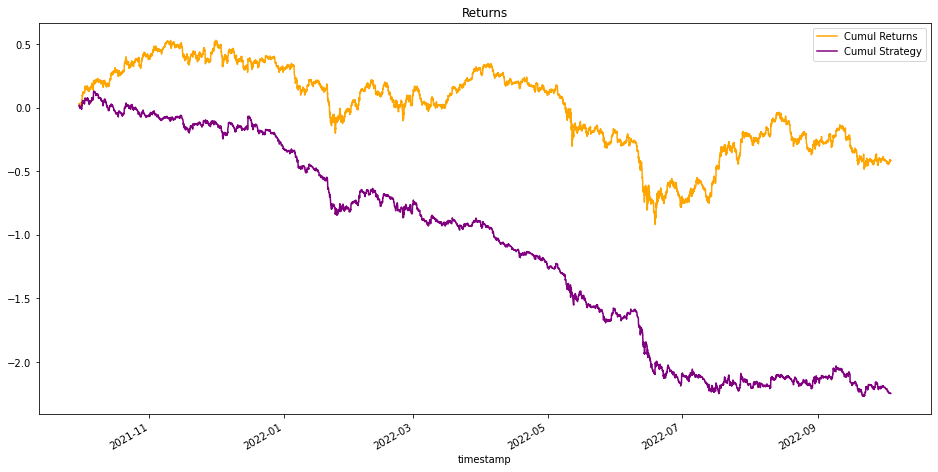

In [45]:
# Visualize the data
eth_df["Cumul Returns"].plot(
    kind='line',
    figsize=(16,8),
    title='Returns',
    color='orange',
    legend= 'ETH Returns'
)
eth_df["Cumul Strategy"].plot(
    kind='line',
    figsize=(16,8),
    color='purple',
    legend= 'Strat Returns'
)

In [46]:
#Print the returns
print('ETH gives a return of', eth_df["Cumul Returns"][-1]*100, '%')
print('The strategy gives a return of', eth_df["Cumul Strategy"][-1]*100, '%')

ETH gives a return of -41.51316821325839 %
The strategy gives a return of -224.79076493153065 %
